Train D=2, param=x
  step 500/3000, loss=0.4371
  step 1000/3000, loss=0.4417
  step 1500/3000, loss=0.3825
  step 2000/3000, loss=0.4178
  step 2500/3000, loss=0.4163
  step 3000/3000, loss=0.3436
Train D=2, param=eps
  step 500/3000, loss=0.5720
  step 1000/3000, loss=0.5336
  step 1500/3000, loss=0.5272
  step 2000/3000, loss=0.4693
  step 2500/3000, loss=0.5192
  step 3000/3000, loss=0.4666
Train D=2, param=v
  step 500/3000, loss=0.9364
  step 1000/3000, loss=0.9044
  step 1500/3000, loss=0.9070
  step 2000/3000, loss=0.8983
  step 2500/3000, loss=0.9220
  step 3000/3000, loss=0.9679
Train D=8, param=x
  step 500/3000, loss=0.0981
  step 1000/3000, loss=0.1080
  step 1500/3000, loss=0.0984
  step 2000/3000, loss=0.1003
  step 2500/3000, loss=0.0936
  step 3000/3000, loss=0.1056
Train D=8, param=eps
  step 500/3000, loss=0.1513
  step 1000/3000, loss=0.1504
  step 1500/3000, loss=0.1587
  step 2000/3000, loss=0.1546
  step 2500/3000, loss=0.1497
  step 3000/3000, loss=0.1600
Train 

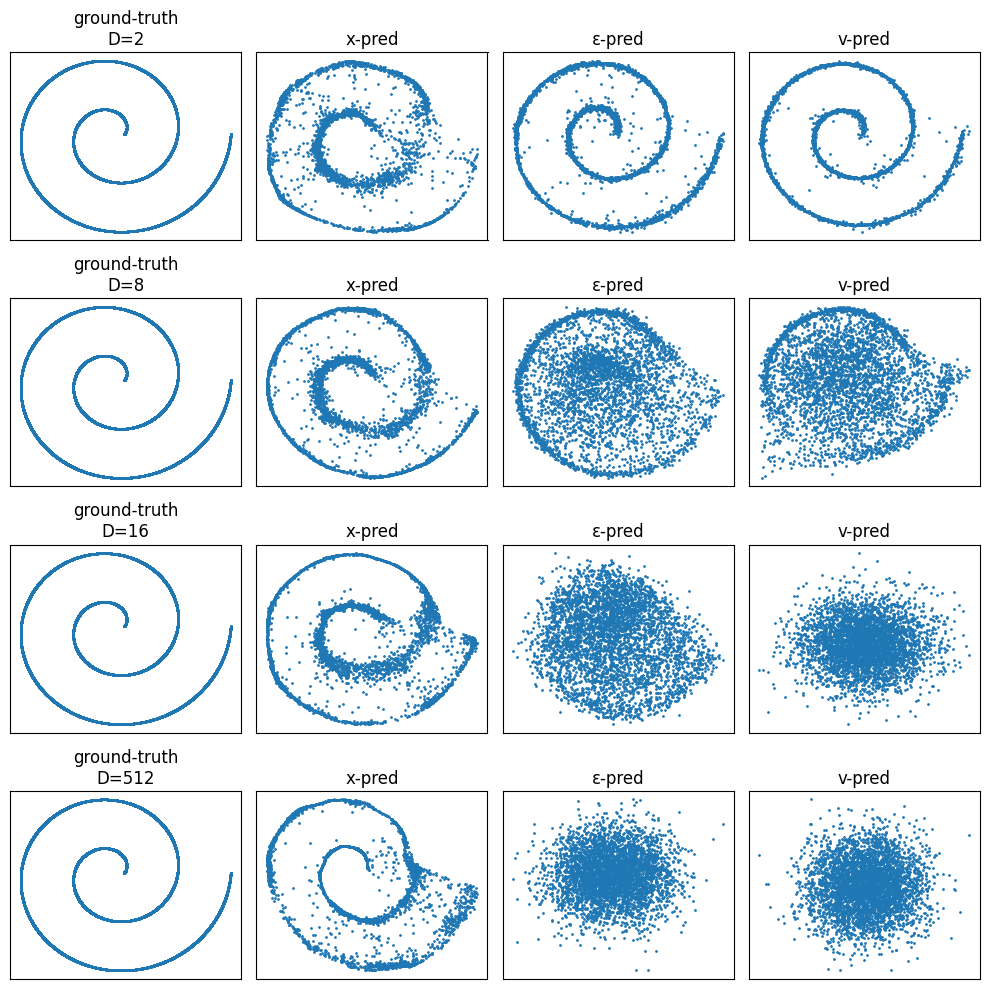

In [1]:
# Toy experiment for "Back to Basics" Fig.2
# - 2D spiral data
# - buried into D-dim with random orthogonal projection
# - diffusion training with x / eps / v prediction
# - DDIM-style sampling, then project back to 2D and plot

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

# -------------------
# data: 2D spiral
# -------------------
def make_spiral(n=20000):
    t = np.linspace(0, 4 * np.pi, n)
    r = np.linspace(0.1, 1.0, n)
    x = r * np.cos(t)
    y = r * np.sin(t)
    data = np.stack([x, y], axis=1).astype(np.float32)
    # normalize to roughly unit variance
    data /= data.std()
    return data

base2d = make_spiral()

# -------------------
# diffusion utils
# -------------------
T = 200               # diffusion steps (작게 잡아서 빠르게)
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def sample_xt(x0, t, noise=None):
    """
    x0: (B, D)
    t: (B,) int64 in [0, T-1]
    """
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = alphas_bar[t].view(-1, 1)
    return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise, noise

# -------------------
# MLP model
# -------------------
class DenoiseMLP(nn.Module):
    def __init__(self, dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x, t):
        # t: (B,) in [0, T-1]
        t = t.float().unsqueeze(1) / (T - 1)
        h = torch.cat([x, t], dim=1)
        return self.net(h)

# -------------------
# training for one D, one parameterization
# -------------------
def train_one(D, param="x", num_steps=4000, batch_size=512, lr=1e-3):
    """
    param in {"x", "eps", "v"}
    """
    print(f"Train D={D}, param={param}")
    # projection: R^2 -> R^D with column-orthogonal matrix P (D x 2)
    rand = torch.randn(D, 2)
    P, _ = torch.linalg.qr(rand)      # (D, 2)
    P = P.to(device)

    data2d = torch.from_numpy(base2d).to(device)  # (N,2)
    x0_D = data2d @ P.T                           # (N,D)

    model = DenoiseMLP(D).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    N = x0_D.shape[0]
    idx_all = torch.arange(N, device=device)

    for step in range(1, num_steps + 1):
        idx = idx_all[torch.randint(0, N, (batch_size,), device=device)]
        x0 = x0_D[idx]
        t = torch.randint(0, T, (batch_size,), device=device)

        xt, noise = sample_xt(x0, t)

        a_bar = alphas_bar[t].view(-1, 1)
        sqrt_ab = torch.sqrt(a_bar)
        sqrt_1mab = torch.sqrt(1 - a_bar)

        if param == "eps":
            target = noise
        elif param == "x":
            target = x0
        elif param == "v":
            # v = sqrt(a_bar)*eps - sqrt(1-a_bar)*x0
            target = sqrt_ab * noise - sqrt_1mab * x0
        else:
            raise ValueError

        pred = model(xt, t)
        loss = F.mse_loss(pred, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % 500 == 0:
            print(f"  step {step}/{num_steps}, loss={loss.item():.4f}")

    return model, P

# -------------------
# convert model output -> (x0_hat, eps_hat)
# -------------------
def model_to_x0_eps(model, x_t, t, param):
    """
    x_t: (B,D), t: (B,) int64
    return x0_hat, eps_hat
    """
    a_bar = alphas_bar[t].view(-1, 1)
    sqrt_ab = torch.sqrt(a_bar)
    sqrt_1mab = torch.sqrt(1 - a_bar)

    out = model(x_t, t)

    if param == "eps":
        eps_hat = out
        x0_hat = (x_t - sqrt_1mab * eps_hat) / sqrt_ab
    elif param == "x":
        x0_hat = out
        eps_hat = (x_t - sqrt_ab * x0_hat) / sqrt_1mab
    elif param == "v":
        # v = sqrt(ab)*eps - sqrt(1-ab)*x0
        v_hat = out
        x0_hat = sqrt_ab * x_t - sqrt_1mab * v_hat
        eps_hat = (x_t - sqrt_ab * x0_hat) / sqrt_1mab
    else:
        raise ValueError

    return x0_hat, eps_hat

# -------------------
# DDIM-style sampling
# -------------------
@torch.no_grad()
def sample(model, D, P, param="x", n_samples=5000):
    """
    returns: (n_samples, 2) in original 2D space
    """
    x_t = torch.randn(n_samples, D, device=device)

    for t_step in reversed(range(T)):
        t = torch.full((n_samples,), t_step, device=device, dtype=torch.long)
        x0_hat, eps_hat = model_to_x0_eps(model, x_t, t, param)

        if t_step == 0:
            x_t = x0_hat
        else:
            a_bar_prev = alphas_bar[t_step - 1]
            a_bar_prev = a_bar_prev.view(1, 1)
            x_t = torch.sqrt(a_bar_prev) * x0_hat + torch.sqrt(1 - a_bar_prev) * eps_hat

    # project back to 2D: x0 = y @ P^T  =>  y = x0 @ P
    x0_2d = x_t @ P           # (n_samples, 2)
    return x0_2d.cpu().numpy()

# -------------------
# run all Ds and params, then plot
# -------------------
Ds = [2, 8, 16, 512]
params = ["x", "eps", "v"]

results = {}   # (D, param) -> (samples_2d, P)

for D in Ds:
    for param in params:
        model, P = train_one(D, param=param, num_steps=3000 if D < 512 else 4000)
        samples_2d = sample(model, D, P, param=param, n_samples=4000)
        results[(D, param)] = (samples_2d, P)

# -------------------
# plot (like Fig.2)
# -------------------
plt.figure(figsize=(10, 10))

def scatter_panel(ax, points, title):
    ax.scatter(points[:,0], points[:,1], s=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

for row_idx, D in enumerate(Ds):
    # ground truth (same for all)
    ax = plt.subplot(len(Ds), 4, row_idx * 4 + 1)
    scatter_panel(ax, base2d, f"ground-truth\nD={D}")

    for col_idx, param in enumerate(params):
        samples_2d, _ = results[(D, param)]
        title = {"x":"x-pred", "eps":"ε-pred", "v":"v-pred"}[param]
        ax = plt.subplot(len(Ds), 4, row_idx * 4 + 2 + col_idx)
        scatter_panel(ax, samples_2d, title)

plt.tight_layout()
plt.show()
